# Project 3A: Multiclass Classification and Neural Networks

## Introduction

In this project, we will implement one-vs-all logistic regression and neural networks to recognize handwritten digits.

In [3]:
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat
import utils

%matplotlib inline

## Multi-class classification

For this section, we will use logistic regression and neural networks to identify handwritten numeric digits (from 0 to 9). Automatic recognition of handwritten digits is widely used today. In the first part of this section, we will extend the implementation of logistic regression that we did in Project 2. As a complement, we will apply one-vs-all classification.

### Dataset

We will use the dataset in `p3data1.mat`, which contains 5000 training examples with handwritten digits (the examples were taken from the [MNIST](http://yann.lecun.com/exdb/mnist) dataset). Each example is a 20x20 pixel grayscale image. Each pixel is represented by a number (a float variable) indicating the intensity at that location. The 20x20 pixel network is converted into a vector of length 400. Each of these training examples is started in a row of the `X` matrix. This makes the `X` matrix 5000x400, where each row is a training example with the image of the handwritten numeric digit.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:- \end{bmatrix} $$

The second part of the training data is the `y` vector of dimension 5000x1 and contains the labels (the correct digit present in each image).

In [4]:
# 20x20 Input Images of Digits
input_layer_size = 400

# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10

#  training data stored in arrays X, y
data = loadmat(os.path.join("data", "p3data1.mat"))
X, y = data["X"], data["y"].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in
# MATLAB where there is no index 0
y[y == 10] = 0

m = y.size

### Visualizing the data

We'll start by visualizing part of our training dataset. In the next cell, the code will randomly select 100 lines of `X` that will serve as input for the `displayData` function. This function maps each line onto a 20x20 pixel grayscale image and displays the images together.

In [ ]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

### Vectorization of Logistic Regression

We will use the one-vs-all logistic regression model to build a multi-class classifier. As there are 10 classes, we will need to separately train 10 classifiers with logistic regression. To test this vectorized logistic regression, we will use custom data, as defined in the following cell.

In [6]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.concatenate(
    [np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order="F") / 10.0], axis=1
)

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# test value for the regularization parameter
lambda_t = 3

#### Vectorizing the cost function

We will start by writing the vectorized version of the cost function. Let's remember that in (unregularized) logistic regression, the cost function is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$

To calculate each element of the sum, we will calculate $h_\theta(x^{(i)})$ for all $i$ examples, where $h_\theta(x^{(i)}) = g(\theta^T x^{(i)})$, where $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. This means that we can calculate it more quickly for all our examples using matrix multiplication. To do this, we'll define $X$ and $\theta$ as

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{e} \qquad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} $$

Thus, calculating the product between the matrices $X\theta$, we get:

$$ X\theta = \begin{bmatrix} - \left( x^{(1)} \right)^T\theta - \\ - \left( x^{(2)} \right)^T\theta - \\ \vdots \\ - \left( x^{(m)} \right)^T\theta - \end{bmatrix} = \begin{bmatrix} - \theta^T x^{(1)}  - \\ - \theta^T x^{(2)} - \\ \vdots \\ - \theta^T x^{(m)}  - \end{bmatrix} $$

In the last equation, we use the fact that $a^Tb = b^Ta$ if $a$ and $b$ are vectors. This allows us to calculate the product $\theta^T x^{(i)}$ for all our examples $i$ in just one line of code.

#### Gradient vectorization

From Project 2, recall that the gradient of the cost in (unregularized) logistic regression is a vector in which the element $j^{th}$ is defined as

$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

To vectorize this operation in the dataset, we start by writing all the explicit partial derivatives for all $\theta_j$,

$$
\begin{align*}
\begin{bmatrix}
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$

where

$$ h_\theta(x) - y =
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)}
\end{bmatrix} $$

Note that $x^{(i)}$ is a vector, while $h_\theta\left(x^{(i)}\right) - y^{(i)}$ is a scalar (a number). To understand the last step of this derivation, take $\beta_i = (h_\theta\left(x^{(m)}\right) - y^{(m)})$ and note that:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix}
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & |
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

where the values $\beta_i = \left( h_\theta(x^{(i)} - y^{(i)} \right)$.

The above expression allows us to calculate all the partial derivatives without using any loops.

#### Vectorization of the regularized logistic regression
Having explained the logistic regression, we will now add the regularization of the cost function. Note that for regularized logistic regression, the cost function is defined as
$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_\theta\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_\theta \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$
Note that you should NOT regularize $\theta_0$, which is used as the bias term. Similarly, the partial derivatives of the logistic regression cost regularized to $\theta_j$ are defined as
$$
\begin{align*}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_0} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \text{for } j \ge 1
\end{align*}
$$
Now we'll write the lrCostFunction code taking regularization into account.

In [7]:
def lrCostFunction(theta, X, y, lambda_):
    """
    Computes the cost of using theta as the parameter for regularized
    logistic regression and the gradient of the cost w.r.t. to the parameters.

    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is
        the number of features including any intercept.

    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (including intercept).

    y : array_like
        The data labels. A vector with shape (m, ).

    lambda_ : float
        The regularization parameter.

    Returns
    -------
    J : float
        The computed value for the regularized cost function.

    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    """
    # Initialize some useful values
    m = y.size
    # convert labels to int if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    J = 0
    grad = np.zeros(theta.shape)
    h = utils.sigmoid(np.dot(X, theta))
    J = (-1 / m) * (np.dot(y, np.log(h)) + np.dot((1 - y), np.log(1 - h)))
    reg_term = (lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)
    J += reg_term
    grad = (1 / m) * np.dot(X.T, (h - y))
    reg_grad_term = (lambda_ / m) * theta[1:]
    grad[1:] += reg_grad_term
    return J, grad

In [ ]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print("Cost : {:.6f}".format(J))
print("Expected cost: 2.534819")
print("-----------------------")
print("Gradient:")
print(" [{:.6f}, {:.6f}, {:.6f}, {:.6f}]".format(*grad))
print("Expected gradient:")
print(" [0.146561, -0.548558, 0.724722, 1.398003]")

### One-vs-all classification
In this section, we will implement one-vs-all classification to train multiple logistic regression classifiers, one for each class $K$ in our dataset. In a dataset of handwritten numeric digits, $K = 10$, but our code should work for any value of $K$.

In [9]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.

    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of
        data points, and n is the number of features. Note that we
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X.

    y : array_like
        The data labels. A vector of shape (m, ).

    num_labels : int
        Number of possible labels.

    lambda_ : float
        The logistic regularization parameter.

    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    """
    # Some useful variables
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    for c in range(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {"maxiter": 50}
        target_class = (y == c).astype(int)
        res = optimize.minimize(
            lrCostFunction,
            initial_theta,
            (X, target_class, lambda_),
            jac=True,
            method="CG",
            options=options,
        )
        all_theta[c, :] = res.x
    return all_theta

After completing the `oneVsAll` code, we can run the next cell to use our implementation to train a multiclass classifier.

In [10]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

#### One-vs-all predictions
After training the one-vs-all classifier, you can use it to predict which digit is handwritten in the image. For each input, we have to calculate the probability that the digit contained in the image belongs to each class. Our one-vs-all prediction function will select the class with the highest probability and return the label (0, 1, ..., K-1) as the prediction for our example input.

In [11]:
def predictOneVsAll(all_theta, X):
    """
    Return a vector of predictions for each example in the matrix X.
    Note that X contains the examples in rows. all_theta is a matrix where
    the i-th row is a trained logistic regression theta vector for the
    i-th class. You should set p to a vector of values from 0..K-1
    (e.g., p = [0, 2, 0, 1] predicts classes 0, 2, 0, 1 for 4 examples) .

    Parameters
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.

    X : array_like
        Data points to predict their labels. This is a matrix of shape
        (m x n) where m is number of data points to predict, and n is number
        of features without the bias term. Note we add the bias term for X in
        this function.

    Returns
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    """
    m = X.shape[0]
    num_labels = all_theta.shape[0]
    p = np.zeros(m)
    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    probabilities = utils.sigmoid(np.dot(X, all_theta.T))
    p = np.argmax(probabilities, axis=1)
    return p

In [ ]:
pred = predictOneVsAll(all_theta, X)
print("Training accuracy: {:.2f}%".format(np.mean(pred == y) * 100))

## Neural Networks
In the previous part of the project, we implemented multiclass logistic regression to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses since it consists of only one linear classifier. We could even add more features to logistic regression, but that would make training too costly.
In this section, we will implement a neural network to recognize handwritten digits using the same training dataset. The neural network will be able to represent more complex models with non-linear hypotheses. For this week, we will use the parameters of an already trained neural network. Our goal is to implement the feedforward algorithm to use our parameters to make predictions. In the next project (P3B), we will implement the backpropagation algorithm to study the parameters of neural networks.
We will start by reloading and visualizing the dataset containing the MNIST handwritten digits.

In [ ]:
#  training data stored in arrays X, y
data = loadmat(os.path.join("data", "p3data1.mat"))
X, y = data["X"], data["y"].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in
# MATLAB where there is no index 0
y[y == 10] = 0

# get number of examples in dataset
m = y.size

# randomly permute examples, to be used for visualizing one
# picture at a time
indices = np.random.permutation(m)

# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

### Model representation

Our neural network model is shown in the following figure.

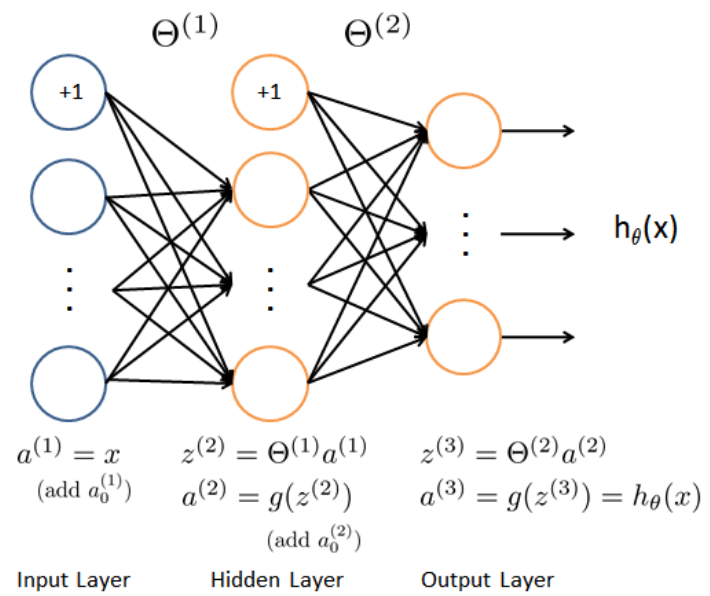

This model has 3 layers: An input layer, a hidden layer and an output layer. Remember that your inputs are pixel values with the image of the digit. Knowing that the images are 20x20, this will result in an input layer of 400 units (excluding an extra bias unit which always generates +1). As previously mentioned, the training data will be loaded into the X and y variables.

The set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) has already been trained previously. This is stored in the file `p3weights.mat`. The next cell loads the parameters in `Theta1` and `Theta2`. The parameters have dimensions that are arranged for a neural network with 25 units in the second layer and 10 units in the output layer (corresponding to the 10 classes).

In [14]:
# Setup the parameters you will use for this exercise
input_layer_size = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25  # 25 hidden units
num_labels = 10  # 10 labels, from 0 to 9

# Load the .mat file, which returns a dictionary
weights = loadmat(os.path.join("data", "p3weights.mat"))

# get the model weights from the dictionary
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights["Theta1"], weights["Theta2"]

# swap first and last columns of Theta2, due to legacy from MATLAB indexing,
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

### Feedforward Propagation and Prediction

We will now implement feedforward propagation for the neural network.

In [15]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network.

    Parameters
    ----------
    Theta1 : array_like
        Weights for the first layer in the neural network.
        It has shape (2nd hidden layer size x input size)

    Theta2: array_like
        Weights for the second layer in the neural network.
        It has shape (output layer size x 2nd hidden layer size)

    X : array_like
        The image inputs having shape (number of examples x image dimensions).

    Return
    ------
    p : array_like
        Predictions vector containing the predicted label for each example.
        It has a length equal to the number of examples.
    """
    # Make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
    # useful variables
    m = X.shape[0]
    num_labels = Theta2.shape[0]
    p = np.zeros(X.shape[0])
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    a2 = utils.sigmoid(np.dot(X, Theta1.T))
    a2 = np.concatenate([np.ones((m, 1)), a2], axis=1)
    a3 = utils.sigmoid(np.dot(a2, Theta2.T))
    p = np.argmax(a3, axis=1)
    return p

Once finished, we will call the function using the parameters loaded for `Theta1` and `Theta2`.

In [ ]:
pred = predict(Theta1, Theta2, X)
print("Training accuracy: {:.1f}%".format(np.mean(pred == y) * 100))

After that, we'll show the images from the training set, one at a time, while printing the predictions for the image shown. We'll run the next cell to show a single image with the neural network's prediction. We can run the cell several times to show the predictions for different images.

In [ ]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    utils.displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print("Neural Network Prediction: {}".format(*pred))
else:
    print("We don't have any more pictures to show")